# Clustering

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)
%config InlineBackend.figure_formats = ['retina']

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("frame3.csv")

In [3]:
df

,S No.,Tag,URL,Raw Transcript,Names,Title,Year,Transcript,runtime,rating,...,s_words,diversity,diversity_ratio,Culture,UK,Crimes,Situational,Immigrants,Relationships,Politics
0,0,\t\t\t\tTom Segura: Sledgehammer (2023) | Tr...,https://scrapsfromtheloft.com/comedy/tom-segur...,"['[clacking]', '[soft bamboo flute notes play]...",\t\t\t\tTom Segura,\t\t\t\tTom Segura: Sledgehammer,2023,hey hey you tell me how have you been ...,61.0,7.1,...,11,1107,0.326741,0.001729,0.013285,0.126248,0.014998,0.004348,0.830967,0.008424
1,1,\t\t\t\tEddie Izzard: Force Majeure Live (20...,https://scrapsfromtheloft.com/comedy/eddie-izz...,['London. Otherwise it would be a little bit t...,\t\t\t\tEddie Izzard,\t\t\t\tEddie Izzard: Force Majeure Live,2013,london otherwise it would be a little bit tric...,85.0,7.3,...,5,1843,0.317978,0.001048,0.990023,0.000878,0.000503,0.000712,0.002136,0.004701
2,2,\t\t\t\tMarlon Wayans: You Know What It Is (...,https://scrapsfromtheloft.com/comedy/marlon-wa...,"['[Hip-hop music playing]', '♪♪', '[Cheers and...",\t\t\t\tMarlon Wayans,\t\t\t\tMarlon Wayans: You Know What It Is,2021,miami make some noise for mr marlon wayans...,58.0,4.0,...,86,1319,0.271009,0.001495,0.002485,0.592501,0.001018,0.001128,0.400080,0.001292
3,3,\t\t\t\tKyle Kinane: Whiskey Icarus (2012) |...,https://scrapsfromtheloft.com/comedy/kyle-kina...,"['Whoo!', 'I’m Kyle Kinane. Kyle Christian Kin...",\t\t\t\tKyle Kinane,\t\t\t\tKyle Kinane: Whiskey Icarus,2012,whoo im kyle kinane kyle christian kinane yeah...,60.0,7.9,...,11,1743,0.341096,0.105144,0.001627,0.099213,0.000956,0.003323,0.786317,0.003420
4,4,\t\t\t\tKyle Kinane: Loose in Chicago (2016)...,https://scrapsfromtheloft.com/comedy/kyle-kina...,"['[indistinct chatter]', 'Ladies and gentlemen...",\t\t\t\tKyle Kinane,\t\t\t\tKyle Kinane: Loose in Chicago,2016,ladies and gentlemen kyle kinane well thank...,77.0,7.1,...,8,1113,0.360311,0.210421,0.001484,0.102548,0.001601,0.006167,0.656735,0.021043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,421,\t\t\t\tLOUIS C.K.: 2017 – Full transcript\t...,https://scrapsfromtheloft.com/comedy/louis-c-k...,['Louis C.K Netflix special filmed in Washingt...,\t\t\t\tLOUIS C.K.,\t\t\t\tLOUIS C.K.: 2017,2017,louis ck netflix special filmed in washington ...,NaN,NaN,...,46,1168,0.287472,0.004457,0.001332,0.001433,0.001133,0.001186,0.942120,0.048339
394,422,\t\t\t\tGeorge Carlin: Jamming in New York (...,https://scrapsfromtheloft.com/comedy/george-ca...,['Jammin’ in New York is George Carlin’s 14th ...,\t\t\t\tGeorge Carlin,\t\t\t\tGeorge Carlin: Jamming in New York,1992,jammin in new york is george carlins album an...,NaN,NaN,...,25,1609,0.371251,0.996354,0.000596,0.000585,0.000545,0.000675,0.000627,0.000619
395,424,\t\t\t\tReggie Watts: Spatial (2016) – Full ...,https://scrapsfromtheloft.com/comedy/reggie-wa...,"['Hello, I’m Thomas. I’m so glad to meet you M...",\t\t\t\tReggie Watts,\t\t\t\tReggie Watts: Spatial,2016,hello im thomas im so glad to meet you mum im...,NaN,NaN,...,7,875,0.389581,0.001625,0.868851,0.002999,0.001553,0.001522,0.121899,0.001552
396,425,\t\t\t\tGEORGE CARLIN: COMPLAINTS AND GRIEVA...,https://scrapsfromtheloft.com/comedy/george-ca...,['Complaints and Grievances is a HBO stand-up ...,\t\t\t\tGEORGE CARLIN,\t\t\t\tGEORGE CARLIN: COMPLAINTS AND GRIEVA...,2001,complaints and grievances is a hbo standup spe...,NaN,NaN,...,33,1680,0.390789,0.995896,0.000746,0.000716,0.000604,0.000631,0.000755,0.000653


[Text(0.5, 0, 'Topics'),
 Text(0, 0.5, 'Mean Percentage per Transcript'),
 (0.0, 0.5)]

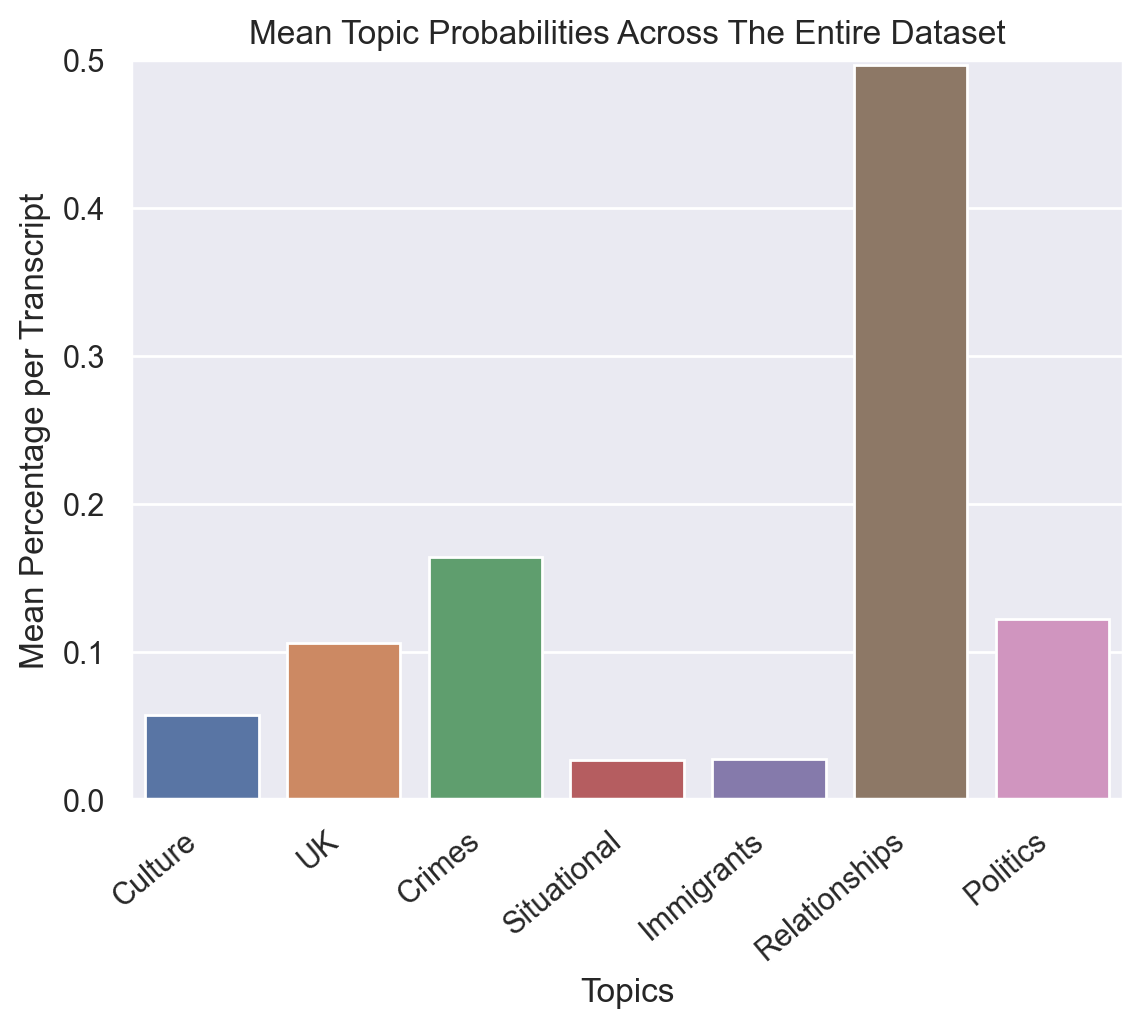

In [4]:
topics = ['Culture', 'UK', 'Crimes', 'Situational', 'Immigrants', 'Relationships', 'Politics']
ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.rating_type == 1].mean())
ax.set_xticklabels(topics, rotation=40, ha='right')
ax.set_title('Mean Topic Probabilities Across The Entire Dataset')
ax.set(xlabel='Topics', ylabel='Mean Percentage per Transcript', ylim=(0, 0.5))

# K-means

In [5]:
# Prepare X
X = df[topics]
X = StandardScaler().fit_transform(X)
X.shape

(398, 7)

In [6]:
# Cluster with differnt n's. Score with silhouette metric
temp_dict = {}
inertias = []
for n_clusters in range(2,15):
    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    temp_dict[n_clusters] = [silhouette_avg] 
    
    inertia = clusterer.inertia_
    print("\tThe inertia is :", inertia)
    inertias.append(inertia)

For n_clusters = 2 The average silhouette_score is : 0.3324728217923275
	The inertia is : 2277.4177786831333
For n_clusters = 3 The average silhouette_score is : 0.406110745292591
	The inertia is : 1878.4956063270922
For n_clusters = 4 The average silhouette_score is : 0.4753725053090379
	The inertia is : 1516.9251754947732
For n_clusters = 5 The average silhouette_score is : 0.5046966379268688
	The inertia is : 1156.9004163206678
For n_clusters = 6 The average silhouette_score is : 0.5652087093612325
	The inertia is : 813.3362020719385
For n_clusters = 7 The average silhouette_score is : 0.5996545241564968
	The inertia is : 454.9760997066545
For n_clusters = 8 The average silhouette_score is : 0.44958948940582444
	The inertia is : 404.5395738804615
For n_clusters = 9 The average silhouette_score is : 0.43038666467854736
	The inertia is : 369.2912591120278
For n_clusters = 10 The average silhouette_score is : 0.4282488963380714
	The inertia is : 338.3195322493864
For n_clusters = 11 Th

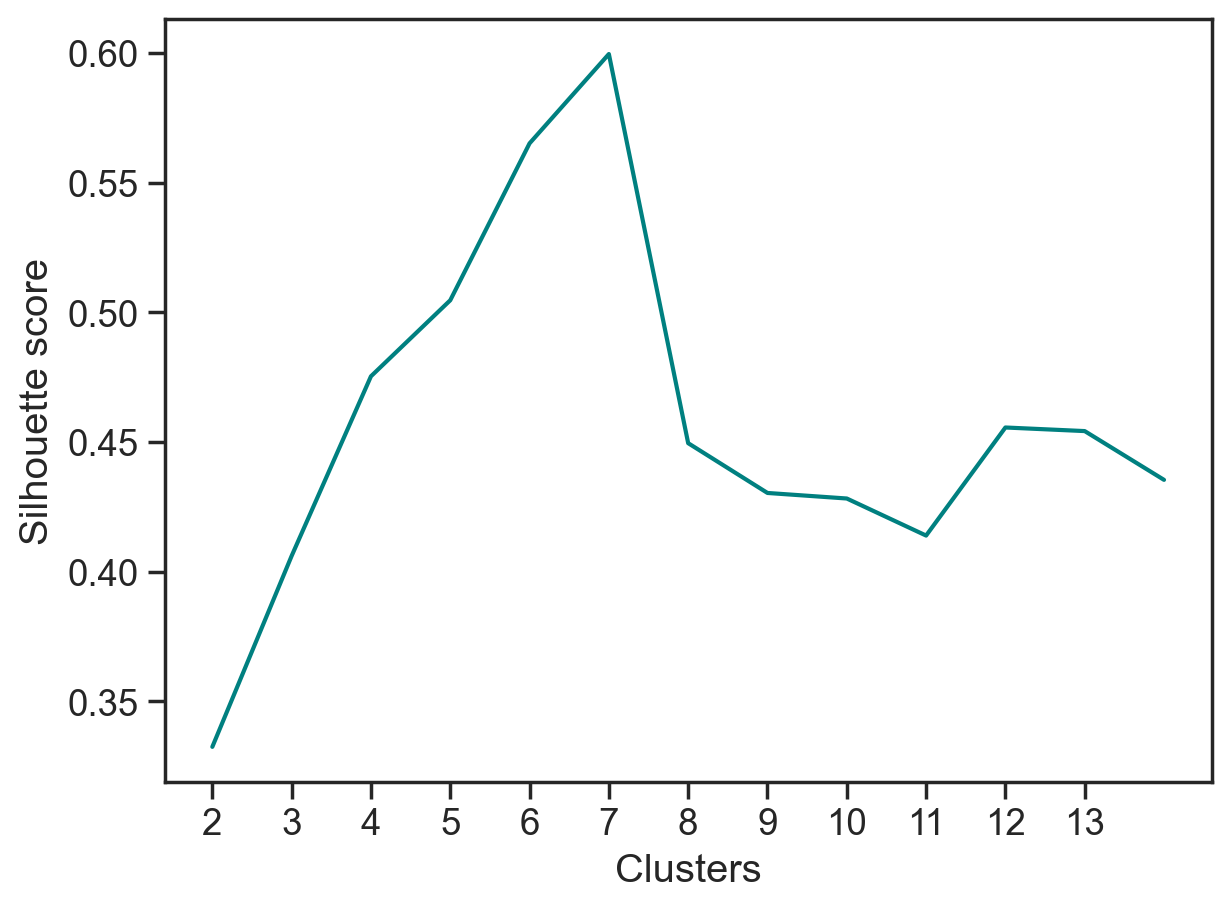

In [7]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
s_scores = pd.DataFrame(temp_dict).T
ax = sns.lineplot(x=s_scores.index, y=s_scores[0], color='teal')
ax.set_xticks(range(2,14))
ax.set_ylabel('Silhouette score')
ax.set_xlabel('Clusters')
ax.figure.tight_layout()

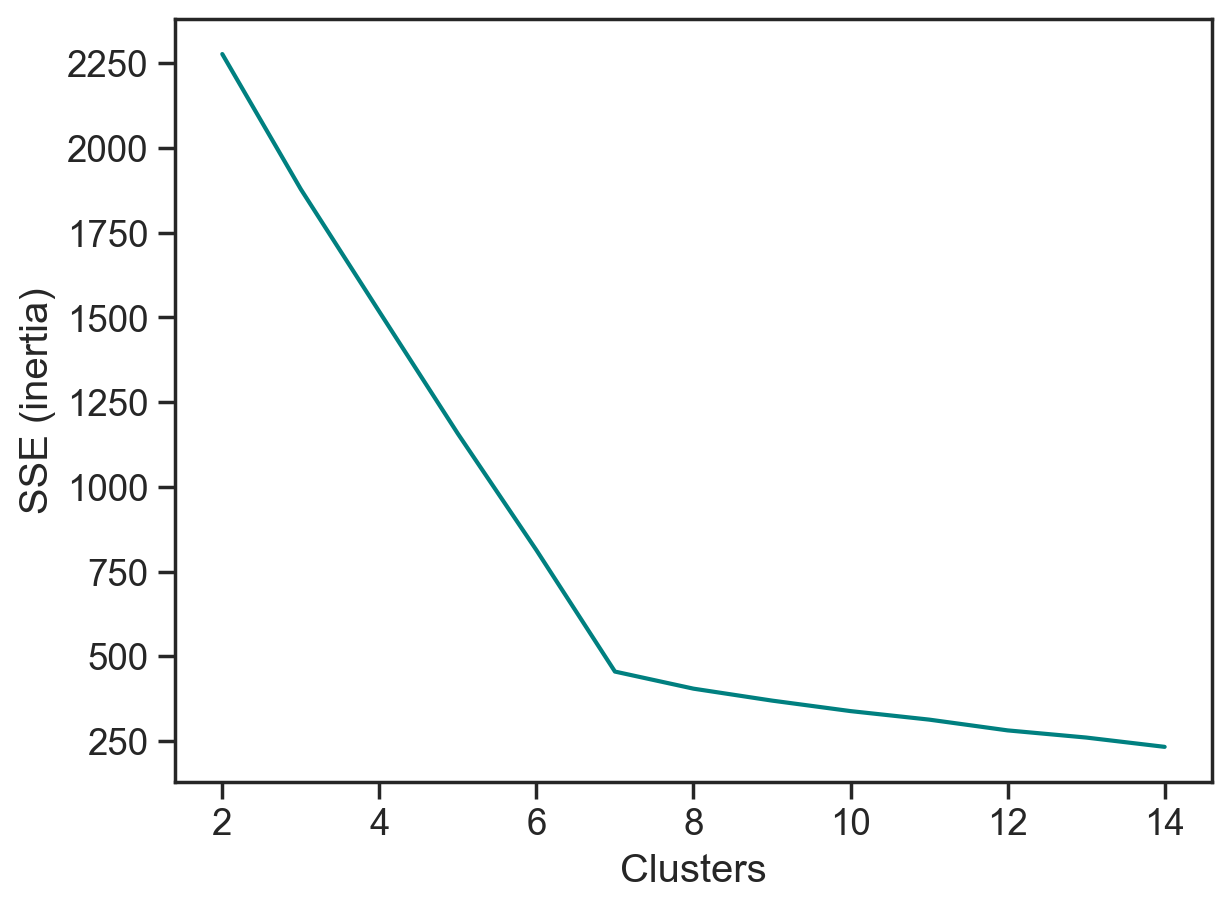

In [9]:
# Create the line plot
ax = sns.lineplot(x=range(2, 15), y=inertias, color='teal')
# Set the y-axis label
ax.set_ylabel('SSE (inertia)')
# Set the x-axis label
ax.set_xlabel('Clusters')
# Adjust the layout of the plot to fit the figure area properly
ax.figure.tight_layout()
# Show the plot
plt.show()

In [10]:
clusterer = KMeans(n_clusters=7, random_state=10)
df['cluster_LDA'] = clusterer.fit_predict(X)

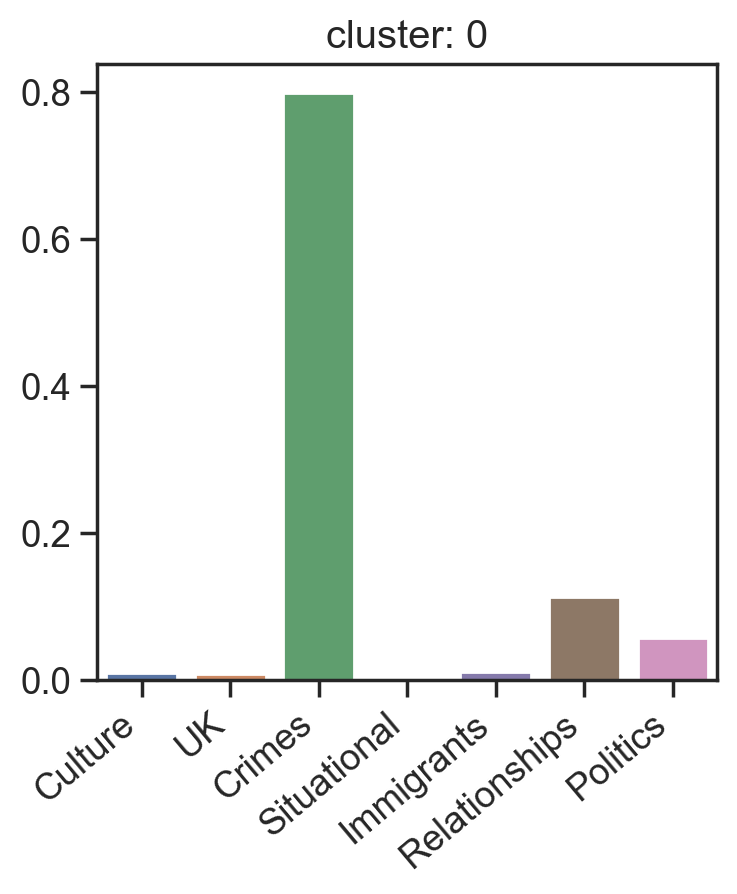

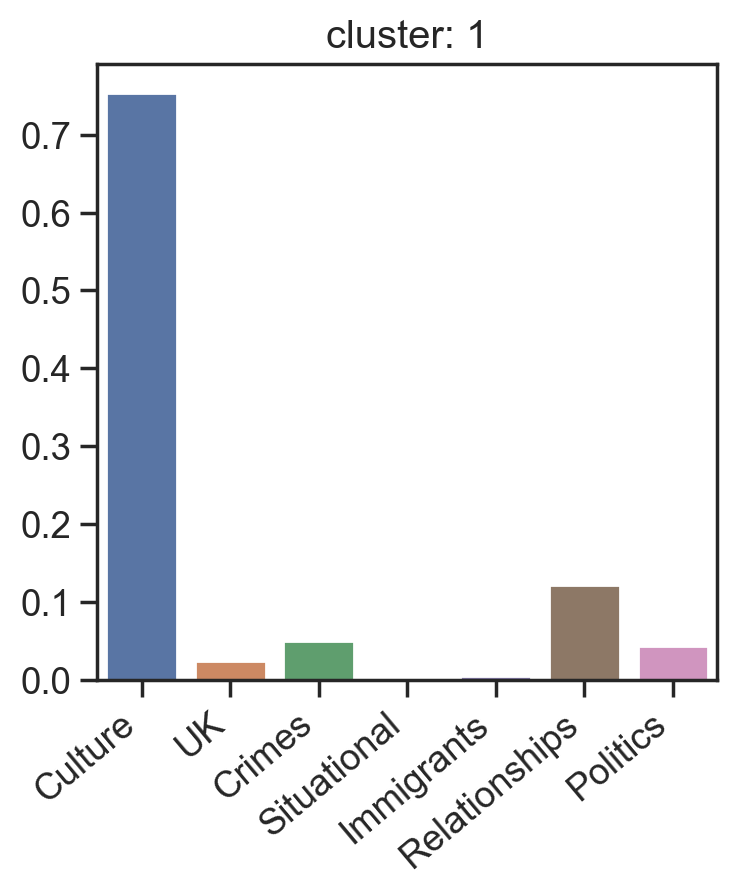

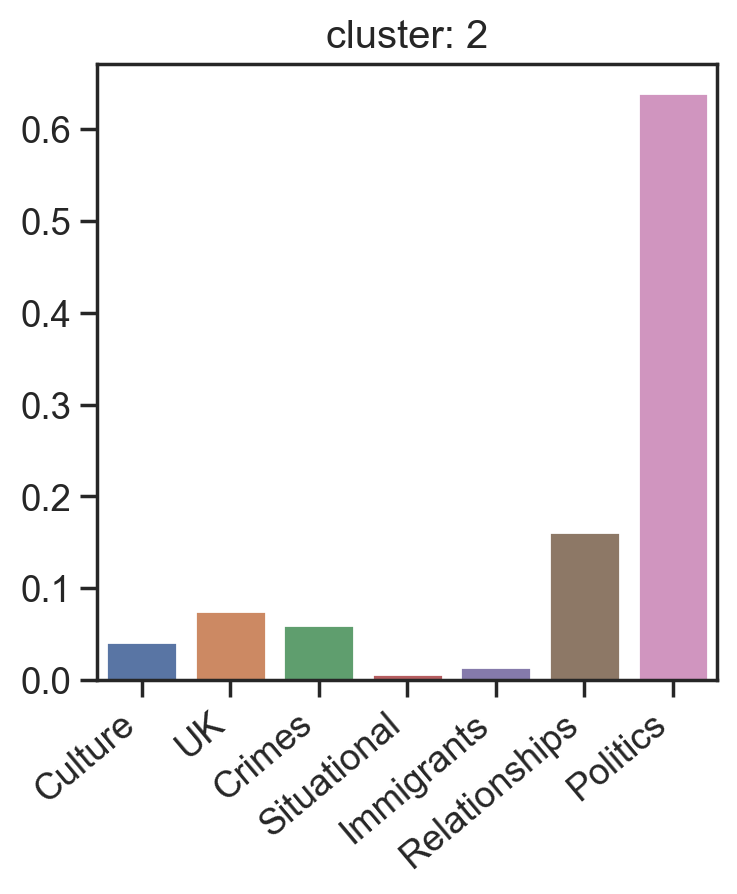

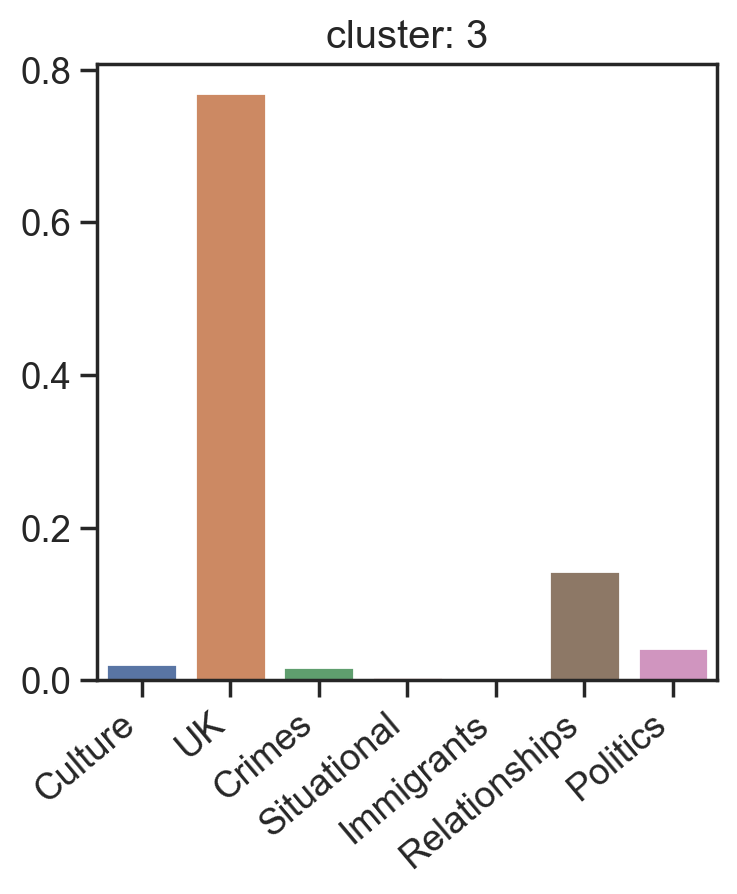

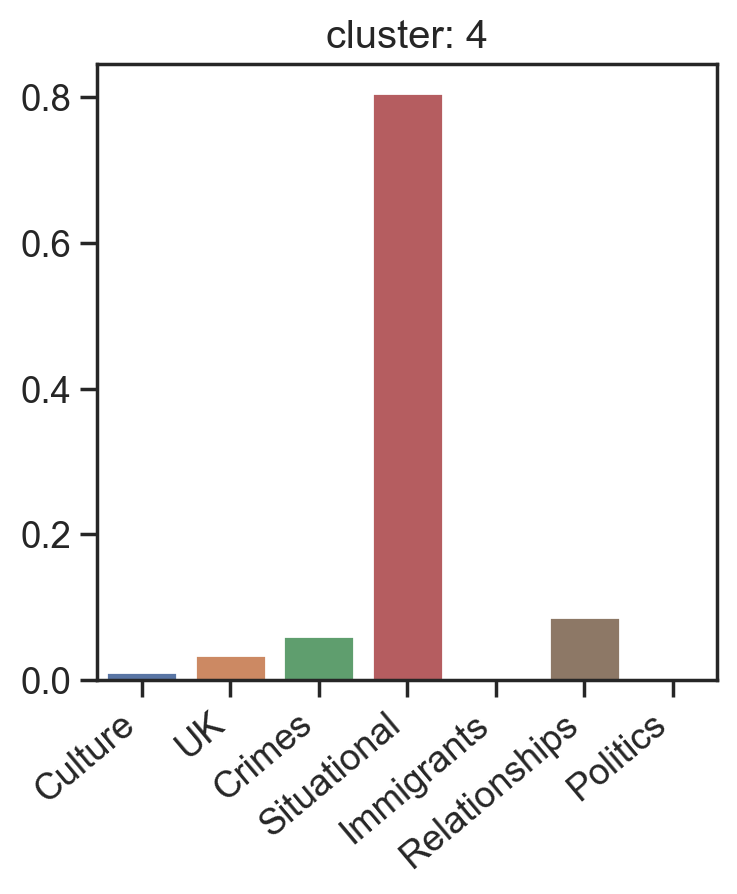

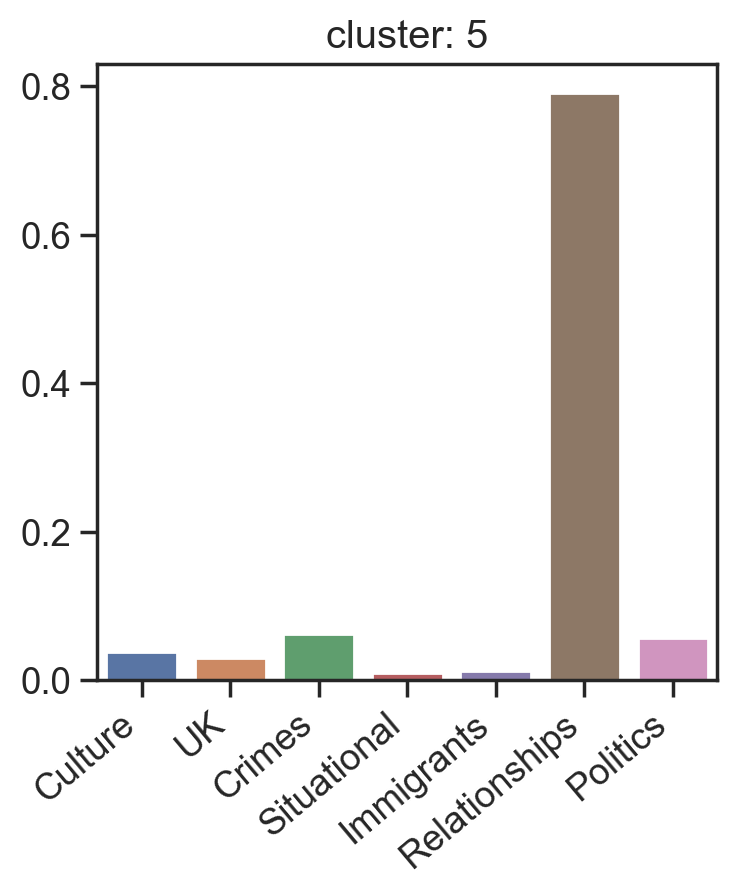

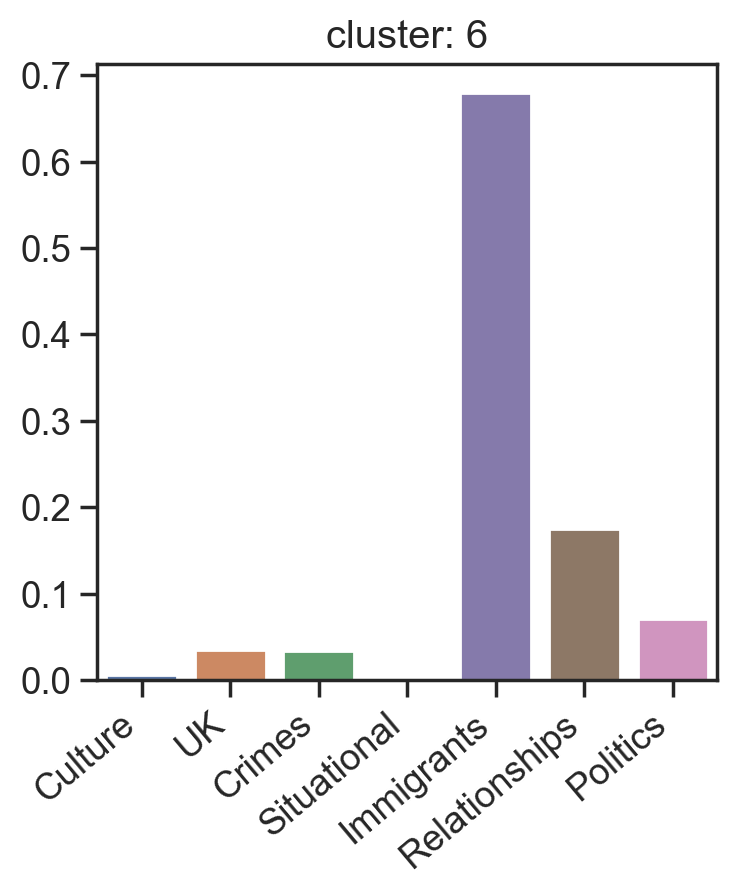

In [11]:
for cluster in range(7):
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)
     
    ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.cluster_LDA == cluster].mean())
    ax.set_xticklabels(topics, rotation=40, ha='right')   
    ax.set_title(f'cluster: {cluster}')

In [12]:
df.cluster_LDA.value_counts()

cluster_LDA
5    212
0     50
2     48
3     40
1     23
6     18
4      7
Name: count, dtype: int64

# TF-IDF

### Clean text (get tri- and bi-grams, lemmatize, and take only selected POS)

In [13]:
# Build bigram and trigram Phrases objects
bigram_phrases = Phrases(df.words, min_count=10)
trigram_phrases = Phrases(bigram_phrases[df.words], min_count=5)

# Create Phraser model objects for faster processing
bigram_model = Phraser(bigram_phrases)
trigram_model = Phraser(trigram_phrases)
trigrams = [trigram_model[bigram_model[word.split()]] for word in df.words]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
lemmatized_words = []
for sent in trigrams:
    doc = nlp(" ".join(sent))
    lemmatized_words.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [14]:
# Prepare for KMeans clustering using Tfidf matrix
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, 
                        lowercase=False,
                        min_df = 10,
                        max_df = 0.4,)   

X = tfidf.fit_transform(lemmatized_words)
X.shape

(398, 5057)

In [15]:
# Cluster with differnt n's. Score with silhouette metric
temp_dict = {}
inertias = []
for n_clusters in range(2,15):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    temp_dict[n_clusters] = [silhouette_avg] 
    
    inertia = clusterer.inertia_
    print("\tThe inertia is :", inertia)
    inertias.append(inertia)

For n_clusters = 2 The average silhouette_score is : 0.010178917384445691
	The inertia is : 365.0507821066385
For n_clusters = 3 The average silhouette_score is : 0.007286928386086826
	The inertia is : 361.83747199687525
For n_clusters = 4 The average silhouette_score is : 0.008084227290673866
	The inertia is : 359.88304691057624
For n_clusters = 5 The average silhouette_score is : 0.007532265121000358
	The inertia is : 358.3664590455038
For n_clusters = 6 The average silhouette_score is : 0.007943812983060052
	The inertia is : 356.64964775102044
For n_clusters = 7 The average silhouette_score is : 0.006852578794899435
	The inertia is : 355.53009249174386
For n_clusters = 8 The average silhouette_score is : 0.005348374010581164
	The inertia is : 353.94281775279615
For n_clusters = 9 The average silhouette_score is : 0.006810674535879022
	The inertia is : 352.41083879162306
For n_clusters = 10 The average silhouette_score is : 0.008607294521990022
	The inertia is : 349.7667622325488
For

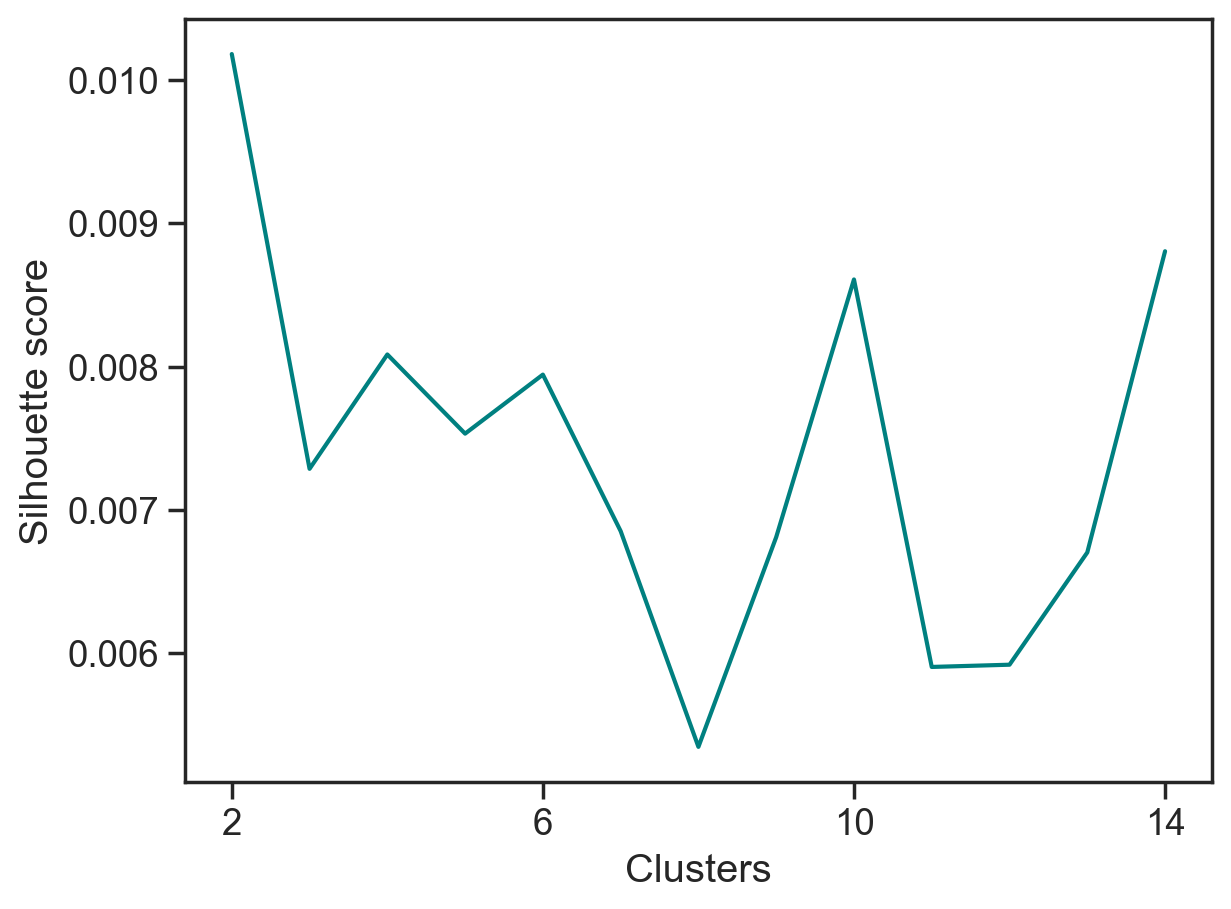

In [16]:
s_scores = pd.DataFrame(temp_dict).T
ax = sns.lineplot(x=s_scores.index, y=s_scores[0], color='teal')
ax.set_xticks(range(2,15, 4))
ax.set_ylabel('Silhouette score')
ax.set_xlabel('Clusters')
ax.figure.tight_layout()

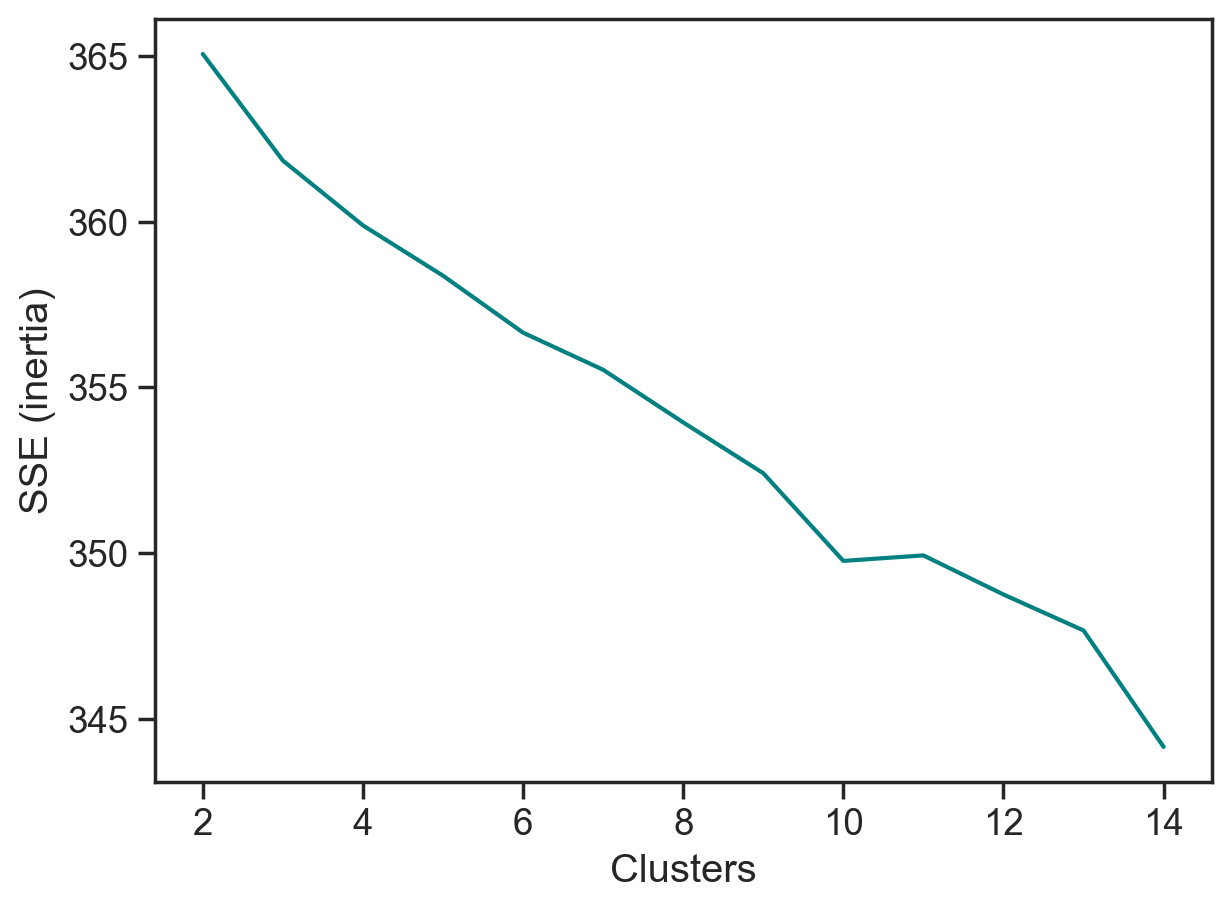

In [18]:
ax = sns.lineplot(x=range(2,15), y=inertias, color='teal')
ax.set_ylabel('SSE (inertia)')
ax.set_xlabel('Clusters')
ax.figure.tight_layout()

In [19]:
clusterer = KMeans(n_clusters=7, random_state=10)
df['cluster_tfidf'] = clusterer.fit_predict(X)

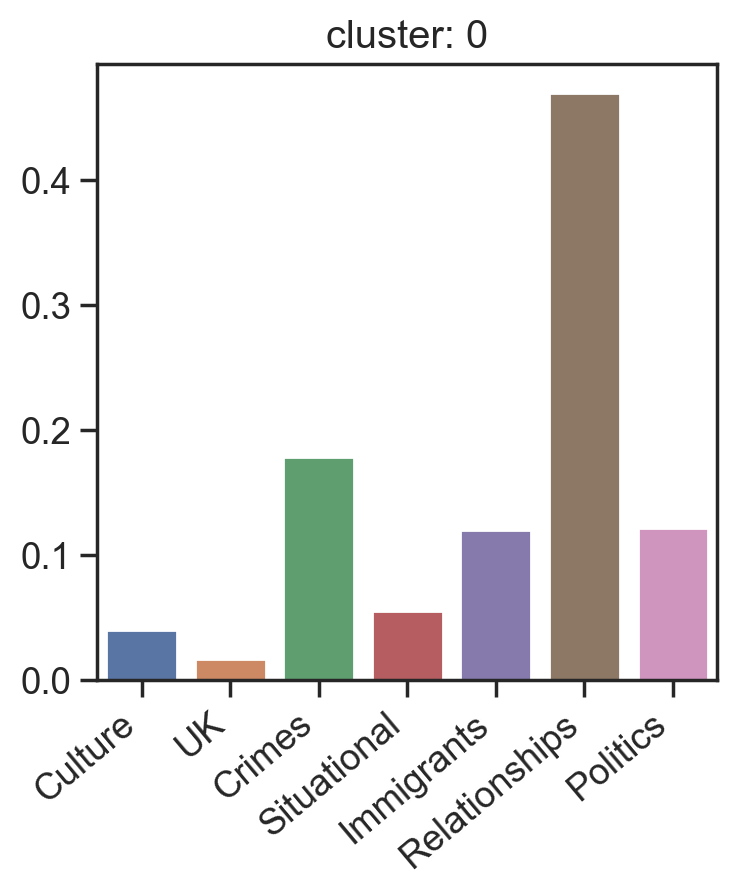

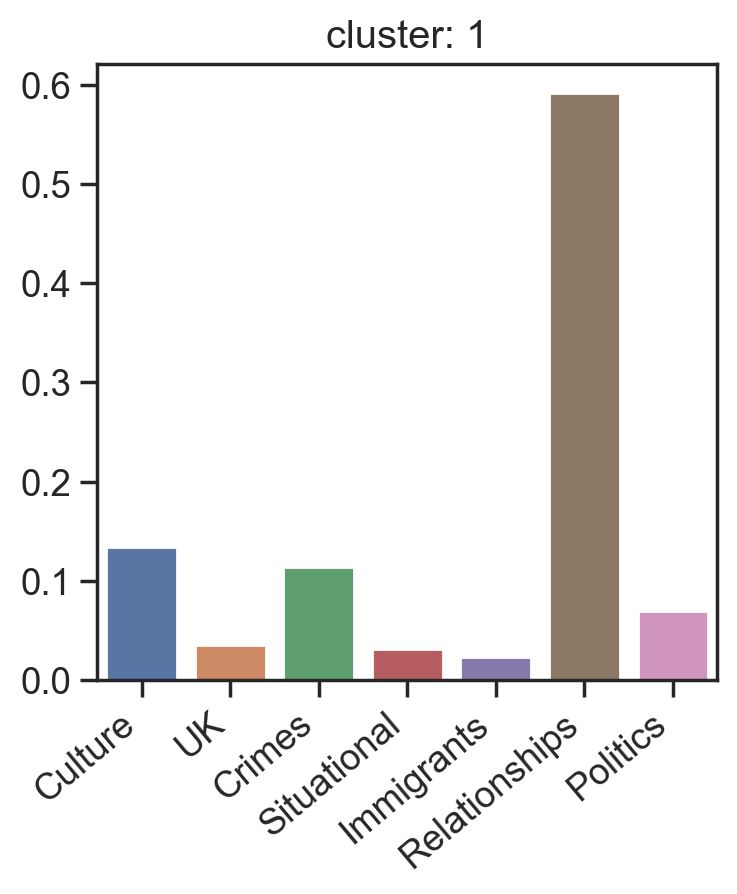

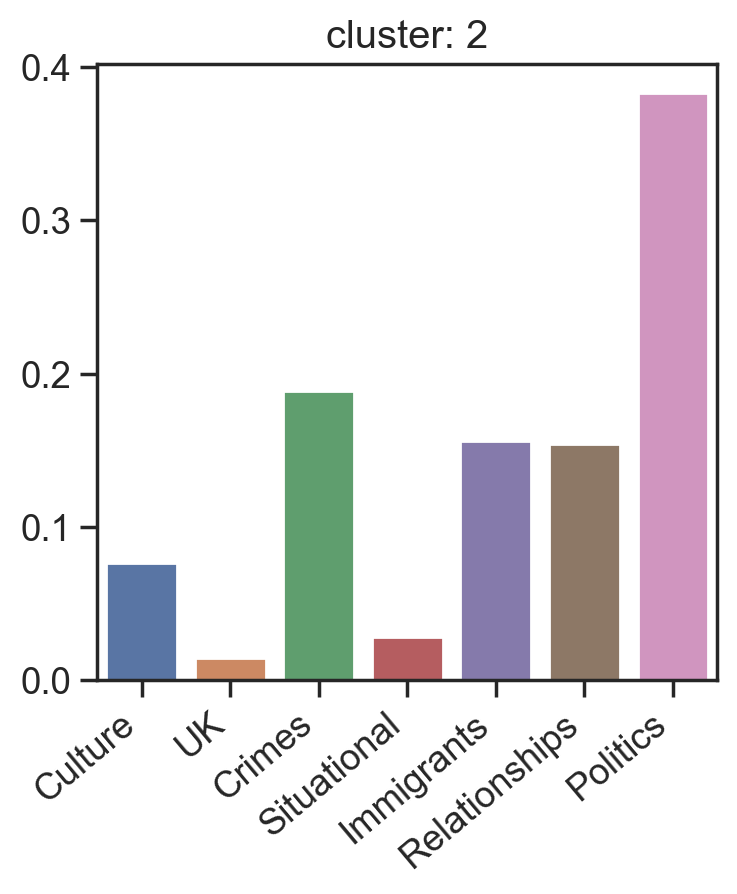

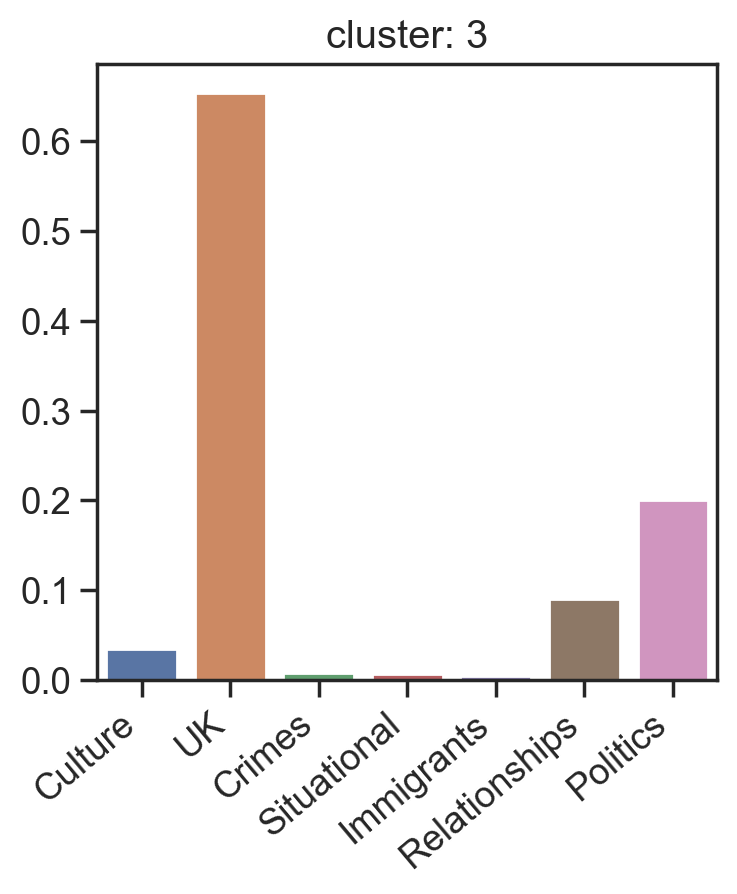

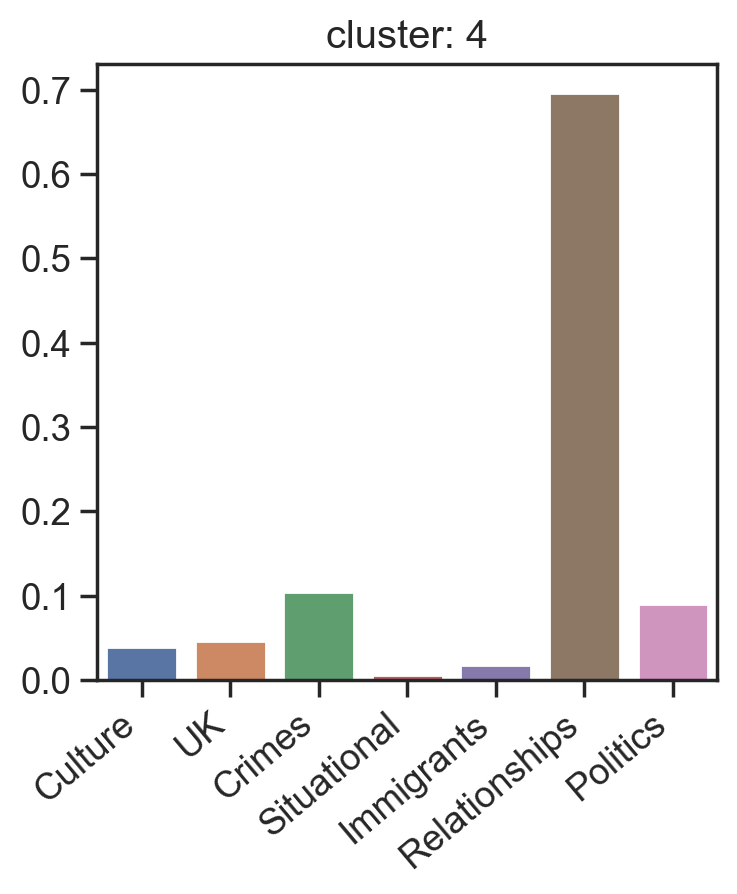

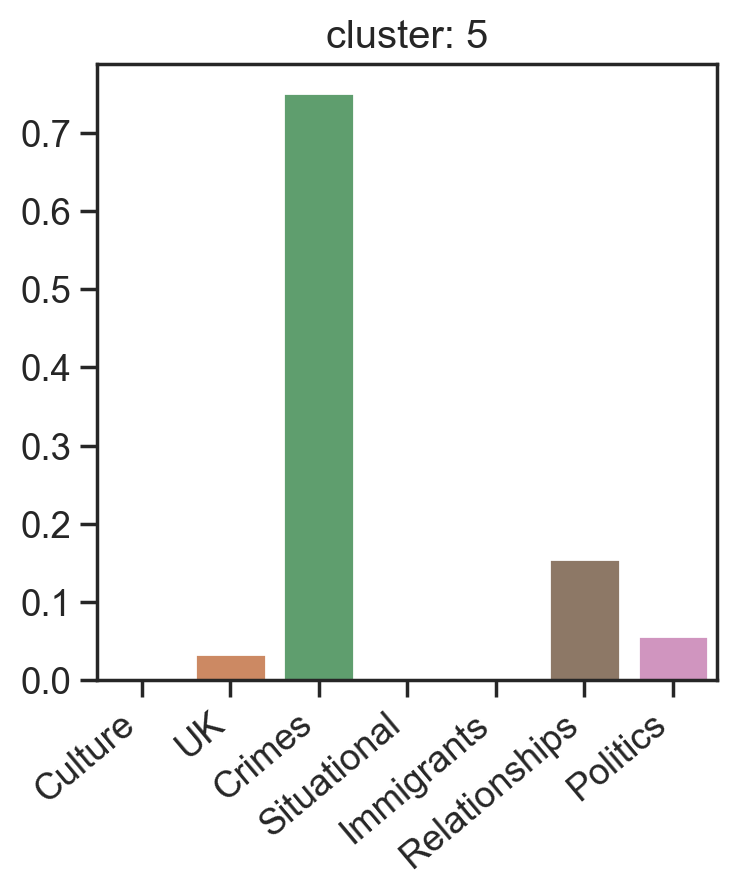

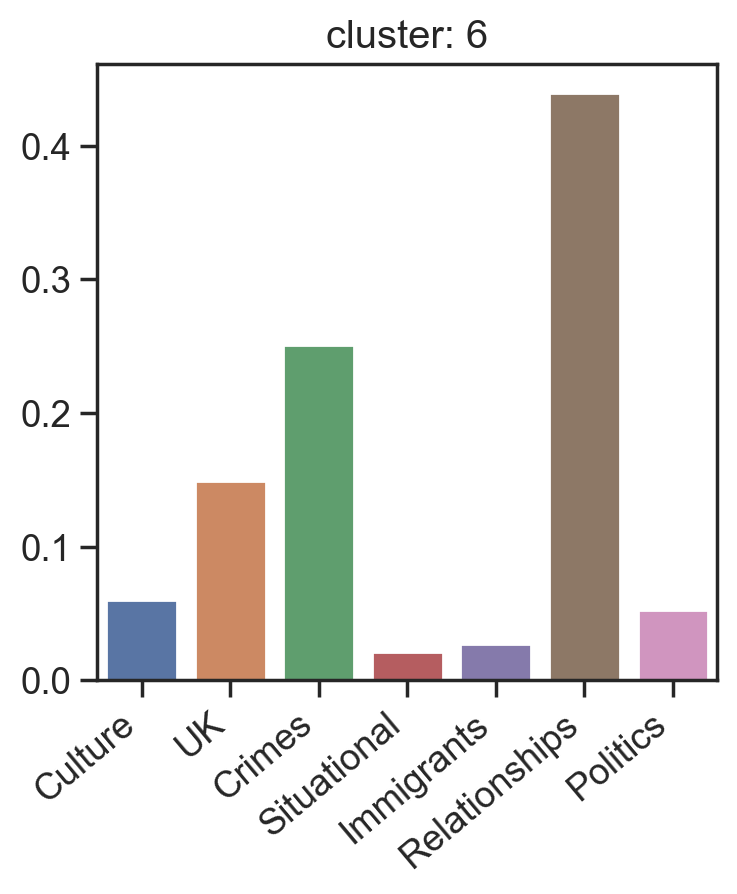

In [20]:
for cluster in range(7):
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)
    
    ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.cluster_tfidf == cluster].mean())
    ax.set_xticklabels(topics, rotation=40, ha='right')   
    ax.set_title(f'cluster: {cluster}')

In [21]:
df.cluster_tfidf.value_counts()

cluster_tfidf
1    124
4    114
2     42
3     41
0     32
6     30
5     15
Name: count, dtype: int64

In [22]:
# Saving the csv file
df.to_csv("frame4.csv", index=False)